In [0]:
import zipfile
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=7a053e3d823b52a171c8b909cc8f2b136b11135d6f23d64240cb4b4005c04240
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=144e49477e1a6e8abf8e9e7c346c10ed122f1445d9d88ef4d3911f633de48230
  Stored in directory: /root/.cache/pip/wheels/52/0c/8e/58d91f29f0f8cbb45231a145312939a5423dc82c61cc731361
Successfully built pretrainedmodels efficientnet-pytorch
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-5lnkm3e7
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-5lnkm3e7
     |████████████████████████████████| 634kB 2.6MB/s 
  Created wheel for albumentations: fi

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Divide images by folders

These steps were made for initial dataset from kaggle (without masks)

In [0]:
root_dir = '/content/steel'
test_dir = root_dir + '/test_images'
train_dir = root_dir + '/train_images'
val_dir = root_dir + '/val_imgs'

train_annot_dir = root_dir + '/train_annot'
test_annot_dir = root_dir + '/test_annot'
val_annot_dir = root_dir + '/val_annot'

predict_dir = root_dir + '/imgs_for_predict'

if not os.path.exists(root_dir):
    os.mkdir(root_dir)
    os.mkdir(train_annot_dir)
    os.mkdir(test_annot_dir)
    os.mkdir(val_dir)
    os.mkdir(val_annot_dir)
    os.mkdir(predict_dir)

In [0]:
# shutil.rmtree(root_dir)

In [0]:
data_path = 'drive/My Drive/'
with zipfile.ZipFile(data_path + 'severstal-steel-defect-detection.zip', 'r') as zip_ref:
    zip_ref.extractall(root_dir)

for img in os.listdir(test_dir):
    shutil.move(test_dir + '/' + img, predict_dir)

In [8]:
sumb_df = pd.read_csv(root_dir + '/sample_submission.csv')
train_df = pd.read_csv(root_dir + '/train.csv')
test_imgs_list = os.listdir(predict_dir)
train_imgs_list = os.listdir(train_dir)
print('Images in prediction folder {} \nImages in training folder {}'.format(len(test_imgs_list), len(train_imgs_list)))

Images in prediction folder 5506 
Images in training folder 12568


In [0]:
train_perc = 90
test_perc = 5
val_perc = 5
assert(train_perc + test_perc + val_perc) == 100

num_train_imgs = len(train_imgs_list)
tr_end = int(num_train_imgs * 0.01 * train_perc)
test_end = tr_end +  int(num_train_imgs * 0.01 * test_perc)
val_end = test_end + int(num_train_imgs * 0.01 * val_perc)

new_train_imgs_list = train_imgs_list[0 : tr_end]
new_test_imgs_list = train_imgs_list[tr_end : test_end]
new_val_imgs_list = train_imgs_list[test_end : val_end]

index = 0
while((len(new_test_imgs_list) + len(new_train_imgs_list) + len(new_val_imgs_list)) != num_train_imgs):
    if ((len(new_test_imgs_list) + len(new_train_imgs_list) + len(new_val_imgs_list)) < num_train_imgs):
        index += 1
        new_val_imgs_list = train_imgs_list[test_end : val_end + index]
    else:
        index -= 1
        new_val_imgs_list = train_imgs_list[test_end : val_end + index]

assert(num_train_imgs) == len(new_train_imgs_list) + len(new_test_imgs_list) + len(new_val_imgs_list)

In [0]:
def move_imgs_to_dir(init_dir, imgs_list, destination_dir):
    for img_name in imgs_list:
        shutil.move(init_dir + '/' + img_name, destination_dir)

move_imgs_to_dir(train_dir, new_test_imgs_list, test_dir)
move_imgs_to_dir(train_dir, new_val_imgs_list, val_dir)

In [11]:
print('Images in train dir {}\nImages in test dir {}\nImages in val dir {}'.format(
    len(os.listdir(train_dir)), len(os.listdir(test_dir)), len(os.listdir(val_dir))
))

Images in train dir 11311
Images in test dir 628
Images in val dir 629


## Create masks for train/test/val images and save them

Work with initial dataset from kaggle (there is no masks)

The dataset was saved locally 'steel_with_masks_256_1600.zip'


In [0]:
def create_mask_img(pixels, img_shape, classid):
    width = img_shape[0]
    height = img_shape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in pixels.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = classid
        current_position += lengths[index]      
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

def create_masks(imgs_list, init_dir, dest_dir):
    for img_name in (imgs_list):
        try:
            new_img_name = dest_dir + '/' + img_name.split('.')[0] + '.png'
            if img_name in train_df['ImageId'].values:
                index = list(train_df['ImageId'].values).index(img_name)
                class_id = train_df['ClassId'].iloc[index]
                img = cv2.imread(init_dir + '/' + img_name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mask = create_mask_img(train_df['EncodedPixels'].iloc[index], 
                                    img.shape, class_id)
                mask_3_ch = np.zeros((img.shape[0], img.shape[1], 3))
                mask_3_ch[:,:,0] = mask
                mask_3_ch[:,:,1] = mask
                mask_3_ch[:,:,2] = mask
                i = 1
                if (index + i != len(train_df)) and (img_name == train_df['ImageId'].iloc[index + i]):
                    while(img_name == train_df['ImageId'].iloc[index + i]):
                        class_id = train_df['ClassId'].iloc[index + i]
                        mask = create_mask_img(train_df['EncodedPixels'].iloc[index + i], 
                                            img.shape, class_id)
                        mask_next = np.zeros((img.shape[0], img.shape[1], 3))
                        mask_next[:,:,0] = mask
                        mask_next[:,:,1] = mask
                        mask_next[:,:,2] = mask
                        mask_3_ch = mask_3_ch + mask_next
                        i += 1
                        if index + i == len(train_df):
                            break
                plt.imsave(new_img_name, mask_3_ch / 255)          
            else:
                img = cv2.imread(init_dir + '/' + img_name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mask_3_ch = np.zeros((img.shape[0], img.shape[1], 3))
                if new_img_name not in os.listdir(dest_dir):
                    plt.imsave(new_img_name, mask_3_ch / 255)
        except Exception as e:
            print(e)
            print(img_name)

In [15]:
# It will take for about 14 minutes
import time
begin = time.time()

create_masks(new_train_imgs_list, train_dir, train_annot_dir)
create_masks(new_test_imgs_list, test_dir, test_annot_dir)
create_masks(new_val_imgs_list, val_dir, val_annot_dir)

end = time.time()
print('It took {} minutes'.format((end - begin) / 60))

It took 14.085969066619873 minutes


In [22]:
# Number of images in each folder
len(os.listdir(train_annot_dir)), len(os.listdir(test_annot_dir)), len(os.listdir(val_annot_dir))

(11311, 628, 629)

In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(28, 30))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

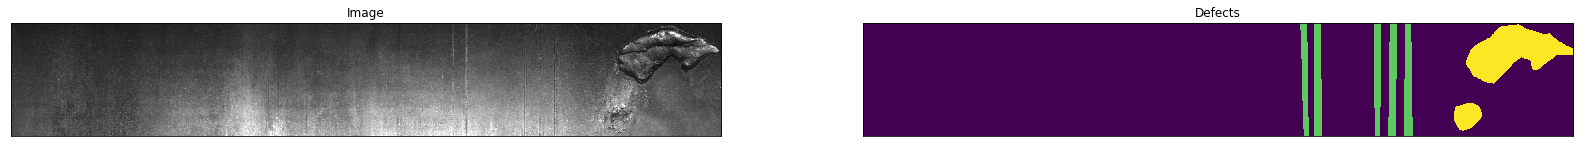

In [26]:
# Steel example with 2-class defects
mask_2_class = cv2.imread(train_annot_dir + '/ee83f88d5.png')
img = cv2.imread(train_dir + '/ee83f88d5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
visualize(
    image = img,
    defects = mask_2_class[:,:,0],
    )

In [27]:
shutil.make_archive('steel', 'zip', root_dir)

'/content/steel.zip'

## Work with dataset which include masks

In [0]:
root_dir = '/content/steel_with_masks_256_1600'
test_dir = root_dir + '/test_images'
train_dir = root_dir + '/train_images'
val_dir = root_dir + '/val_imgs'

train_annot_dir = root_dir + '/train_annot'
test_annot_dir = root_dir + '/test_annot'
val_annot_dir = root_dir + '/val_annot'

predict_dir = root_dir + '/imgs_for_predict'

data_path = 'drive/My Drive/'
with zipfile.ZipFile(data_path + '/steel_with_masks_256_1600.zip', 'r') as zip_ref:
    zip_ref.extractall(root_dir)

In [30]:
print('Images in train dir {}\nImages in test dir {}\nImages in val dir {}'.format(
    len(os.listdir(train_annot_dir)), len(os.listdir(test_annot_dir)), len(os.listdir(val_annot_dir))
))

Images in train dir 11311
Images in test dir 628
Images in val dir 629


In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(28, 30))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

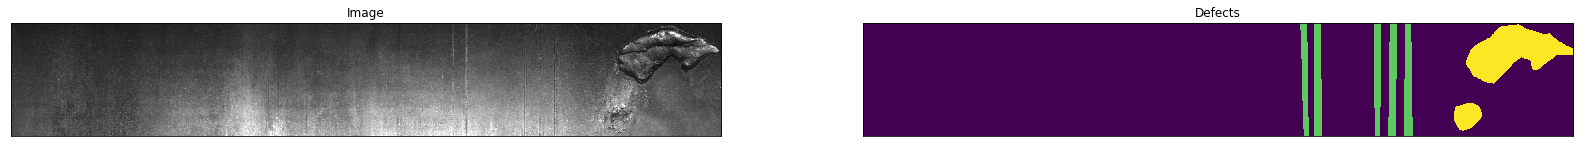

In [32]:
mask_2_class = cv2.imread(train_annot_dir + '/ee83f88d5.png')
img = cv2.imread(train_dir + '/ee83f88d5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
visualize(
    image = img,
    defects = mask_2_class[:,:,0],
    )

## Delete all images and masks without defects

Then save dataset

In [47]:
shutil.copytree(root_dir, '/content/steel_with_defects_dataset_256_1600')

'/content/steel_with_defects_dataset_256_1600'

In [0]:
defects_dataset_dir = '/content/steel_with_defects_dataset_256_1600'
for path in os.walk(defects_dataset_dir):
    if path[0] != defects_dataset_dir and path[0] != (defects_dataset_dir + '/imgs_for_predict'):
        img_list = os.listdir(path[0])
        for img in img_list:
            if (img.split('.')[0] + '.jpg') not in train_df['ImageId'].values:
                os.remove(path[0] + '/' + img)

In [49]:
for path in os.walk(defects_dataset_dir):
    if path[0] != defects_dataset_dir and path[0] != (defects_dataset_dir + '/imgs_for_predict'):
        img_list_len = len(os.listdir(path[0]))
        print('{},   {}'.format(path[0], img_list_len))

/content/steel_with_defects_dataset_256_1600/test_annot,   312
/content/steel_with_defects_dataset_256_1600/train_annot,   6003
/content/steel_with_defects_dataset_256_1600/val_imgs,   351
/content/steel_with_defects_dataset_256_1600/test_images,   312
/content/steel_with_defects_dataset_256_1600/val_annot,   351
/content/steel_with_defects_dataset_256_1600/train_images,   6003


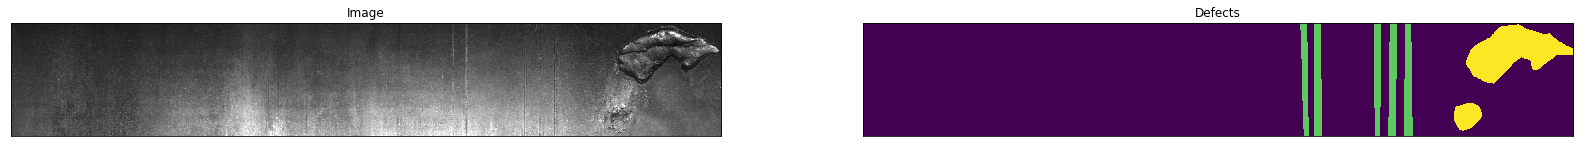

In [50]:
mask_2_class = cv2.imread('/content/steel_with_defects_dataset_256_1600/train_annot' + '/ee83f88d5.png')
img = cv2.imread('/content/steel_with_defects_dataset_256_1600/train_images' + '/ee83f88d5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
visualize(
    image = img,
    defects = mask_2_class[:,:,0],
    )

In [51]:
shutil.make_archive('steel_defects_only', 'zip', defects_dataset_dir)

'/content/steel_defects_only.zip'

## Work with datasets only with defects

In [0]:
root_dir = '/content/steel_defects_only_256_1600_v2'
test_dir = root_dir + '/test_images'
train_dir = root_dir + '/train_images'
val_dir = root_dir + '/val_imgs'
predict_annot_dir = root_dir + '/predict_annot'

train_annot_dir = root_dir + '/train_annot'
test_annot_dir = root_dir + '/test_annot'
val_annot_dir = root_dir + '/val_annot'

predict_dir = root_dir + '/imgs_for_predict'

data_path = 'drive/My Drive'
with zipfile.ZipFile(data_path + '/steel_defects_only_256_1600_v2.zip', 'r') as zip_ref:
    zip_ref.extractall(root_dir)

In [41]:
print('Images in train dir {}\nImages in test dir {}\nImages in val dir {}\nPredict images {}'.format(
    len(os.listdir(train_dir)), len(os.listdir(test_dir)), len(os.listdir(val_dir)),
    len(os.listdir(predict_annot_dir))
))

Images in train dir 6003
Images in test dir 312
Images in val dir 351
Predict images 5506


In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(28, 30))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

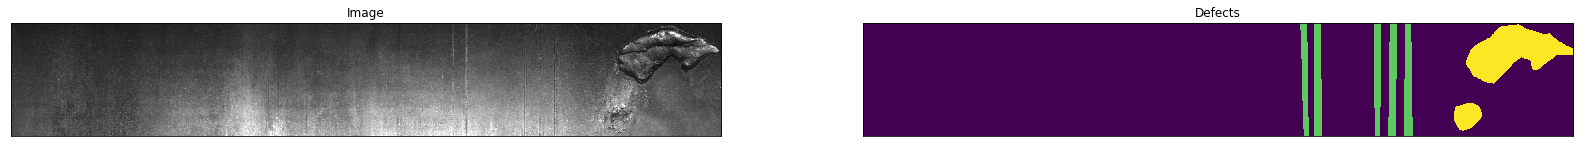

In [43]:
mask_2_class = cv2.imread(train_annot_dir + '/ee83f88d5.png')
img = cv2.imread(train_dir + '/ee83f88d5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
visualize(
    image = img,
    defects = mask_2_class[:,:,0],
    )

## Create datasets and visualize images

In [0]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [0]:
class Dataset(BaseDataset):
    """Severstal defects Dataset. Read images, apply augmentation and preprocessing transformations.
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """
    
    CLASSES = ['background', 'class_1', 'class_2', 'class_3', 'class_4',]
    
    def __init__(
            self, 
            images_dir, 
            masks_dir,
            img_shape=(1600, 256), 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.img_shape = img_shape
        self.images_ids = np.sort(os.listdir(images_dir))
        self.masks_ids = np.sort(os.listdir(masks_dir))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.images_ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.masks_ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_shape)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, self.img_shape)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_ids)

/content/steel_defects_only_256_1600_v2/val_imgs/2e35ebe13.jpg


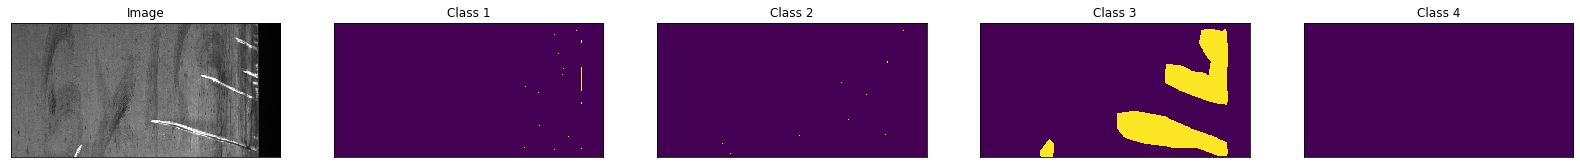

/content/steel_defects_only_256_1600_v2/val_imgs/2e4da1fd1.jpg


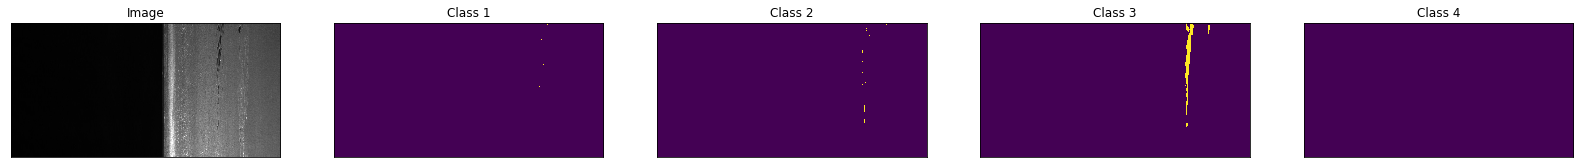

/content/steel_defects_only_256_1600_v2/val_imgs/308cc088e.jpg


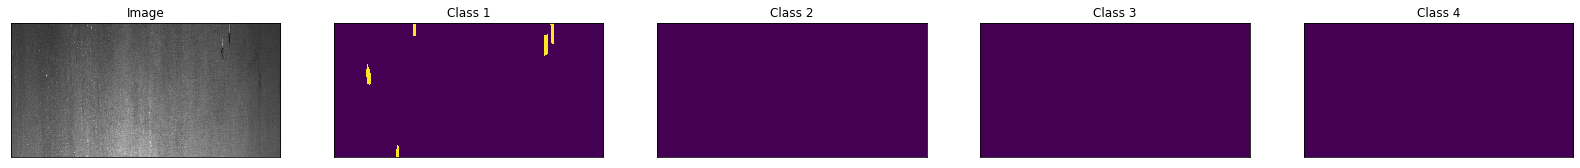

/content/steel_defects_only_256_1600_v2/val_imgs/321a6df3f.jpg


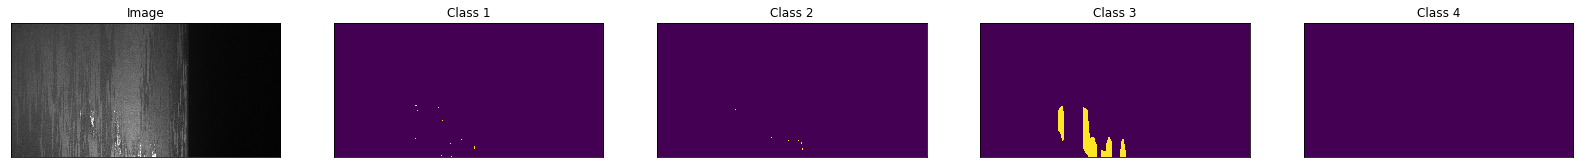

/content/steel_defects_only_256_1600_v2/val_imgs/3266ff34d.jpg


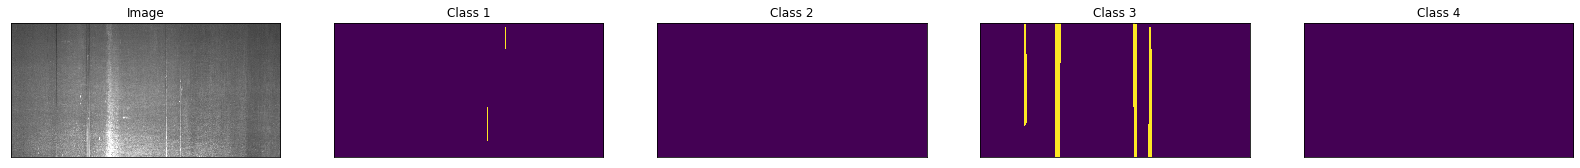

In [47]:
train_dataset = Dataset(train_dir, train_annot_dir, (512,256), classes=['class_1', 'class_2', 'class_3', 'class_4'])
test_dataset = Dataset(test_dir, test_annot_dir, (512,256), classes=['class_1', 'class_2', 'class_3', 'class_4'])
val_dataset = Dataset(val_dir, val_annot_dir, (512,256), classes=['class_1', 'class_2', 'class_3', 'class_4'])

# example of some images and their defects
for index in range(70,75):
    image, mask = val_dataset[index]
    print(val_dataset.images_fps[index])
    visualize(
        image=image, 
        class_1 = mask[:,:,0].squeeze(),
        class_2 = mask[:,:,1].squeeze(),
        class_3 = mask[:,:,2].squeeze(),
        class_4 = mask[:,:,3].squeeze(),
    )

In [0]:
import albumentations as albu

In [0]:
def get_training_augmentation():
    train_transform = [

        albu.OneOf(
            [
             albu.HorizontalFlip(p=0.5),
             albu.VerticalFlip(p=0.5),
             albu.RandomBrightnessContrast(p=0.5)
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.PadIfNeeded(256, 1600)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
   
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

## Train segmentation model

**The place for writing results of training**

---
**1. se_resnext50_32x4d**
- FPN model
- Images were preprocessed to (3,320,320) shape becuse of pretreined weights
- 751 batches images by 8 imgs (only with defects)
- One epoch takes ~ 3,5 minutes
- Batch size = 8 (train) and 1 (validation)

*Result: the model got stuck and the best epoch is 0. Loss and IoU metric are the same for the whole training process. No I'll try to change se_resnext50 to resnet34 pretrained weights. Maybe the problem is the weights*

**2.Change the pretrained weights to resnet34 and model from FPN to Unet. All parameters are the same**

*Result: model become worse and worse at each epoch. The speed of training increased*

**3. Resize images to (512,256) shape. Change augmentation leaving just Vertical, Horizontal flips and RandomBrightnessContrast**

*Result: No results*

**4. Change Dice to BCE loss. resnet34 to efficientnet-b3. Batch size from 8 to 24**

*Result: Everythin is good but the training process is slow. Try to change lr from 0.0001 to 0.001*

**5. Tryied to find the best parameters. Trained on resnet50, Unet. Learning rate = 0.001. The result on prediction samples is awkward. Try to find another ways of trainning model.**

'Maybe I should change to sigmoid from softmax.'

And try efficientnet-b3 again

In [0]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [0]:
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['class_1', 'class_2', 'class_3', 'class_4']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

cache_folder = '/root/.cache/torch/checkpoints'

# shutil.copy('/content/drive/My Drive/segmentatio_pretrained_weights/se_resnext50_32x4d-a260b3a4.pth', cache_folder)

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [0]:
train_dataset = Dataset(
    train_dir, 
    train_annot_dir, 
    (512,256),
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

val_dataset = Dataset(
    val_dir, 
    val_annot_dir,
    (512,256),
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

In [59]:
image, mask = train_dataset[17]
image.shape

(3, 256, 512)

In [0]:
# for i in range(3):
#     image, mask = train_dataset[5]
#     visualize(
#         image=image, 
#         class_1 = mask[:,:,0].squeeze(),
#         class_2 = mask[:,:,1].squeeze(),
#         class_3 = mask[:,:,2].squeeze(),
#         class_4 = mask[:,:,3].squeeze(),
#     )

In [0]:
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [0]:
loss = smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.IoU(),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.005),
])

In [0]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Train model

In [0]:
# torch.cuda.empty_cache()


# max_score = 0

# for i in range(0, 50):
    
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     val_logs = val_epoch.run(val_loader)
    
#     # do something (save model, change lr, etc.)
#     if max_score < val_logs['iou_score']:
#         max_score = val_logs['iou_score']
#         torch.save(model, './steel_best_model_' + str(i) + '_epoch_' + ENCODER + '.pth')
#         print('Model saved!')
        
#     if i == 40:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')

In [0]:
shutil.copy('/content/drive/My Drive/steel_best_model_27_epoch_efficientnet-b3_unet.pth', '/content')

best_model = torch.load('./steel_best_model_27_epoch_efficientnet-b3_unet.pth')
# best_model = torch.load('/content/model.pth')

In [0]:
test_dataset = Dataset(
    test_dir, 
    test_annot_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [67]:
img, mask = test_dataset[5]
img.shape

(3, 256, 1600)

In [68]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 312/312 [00:22<00:00, 14.18it/s, bce_loss - 0.04636, iou_score - 0.3734]


In [0]:
test_dataset_vis = Dataset(
    test_dir, test_annot_dir, 
    classes=CLASSES,
)

522d34082.jpg
TRUTH


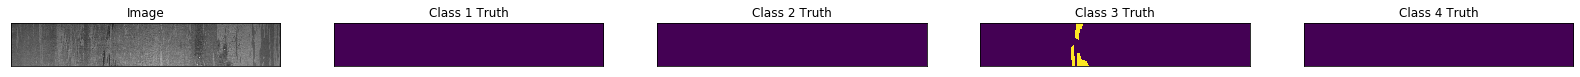

PREDICTED


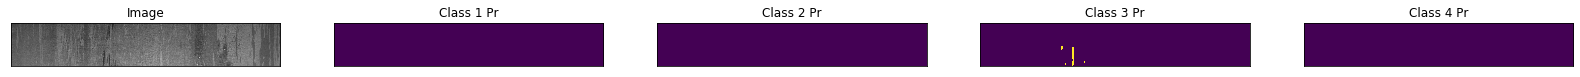




9028ff68e.jpg
TRUTH


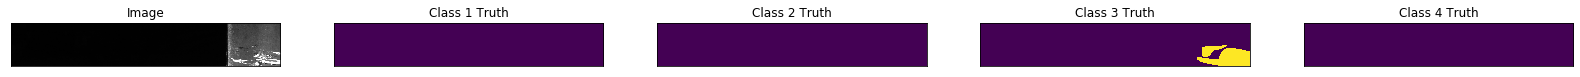

PREDICTED


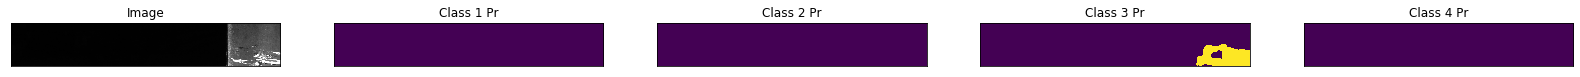




34ee04d85.jpg
TRUTH


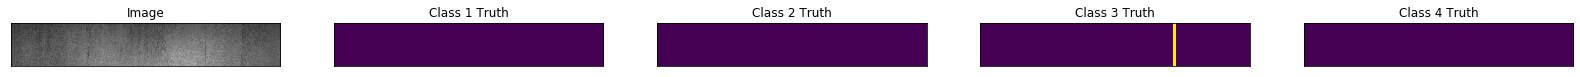

PREDICTED


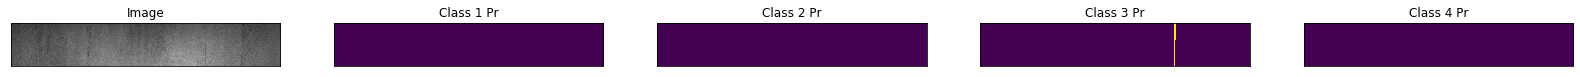




0fd171923.jpg
TRUTH


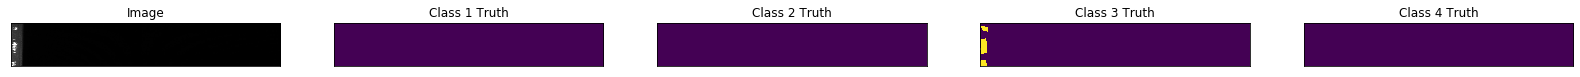

PREDICTED


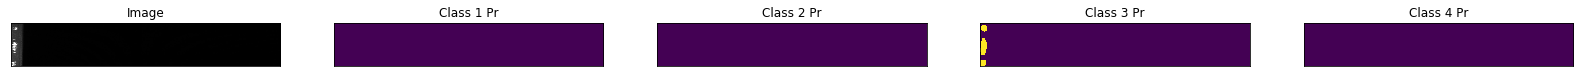




f7916450e.jpg
TRUTH


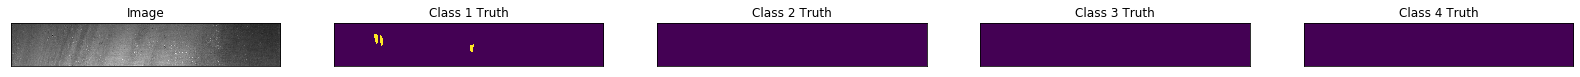

PREDICTED


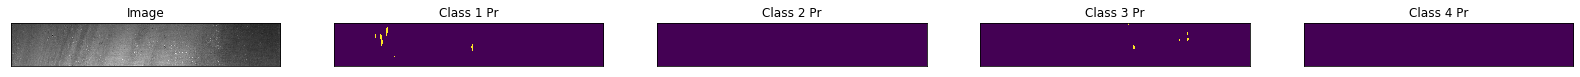




514222386.jpg
TRUTH


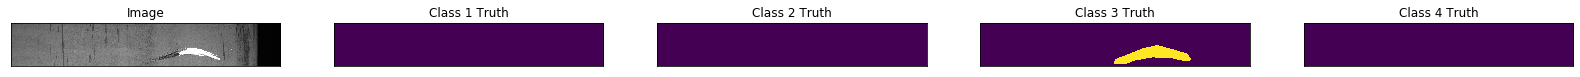

PREDICTED


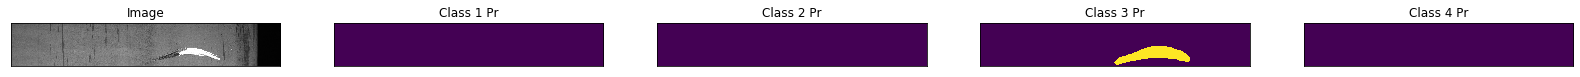




c2d0a2e19.jpg
TRUTH


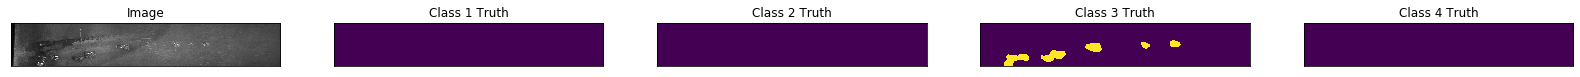

PREDICTED


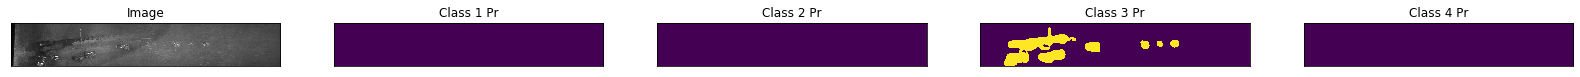




6e785e50c.jpg
TRUTH


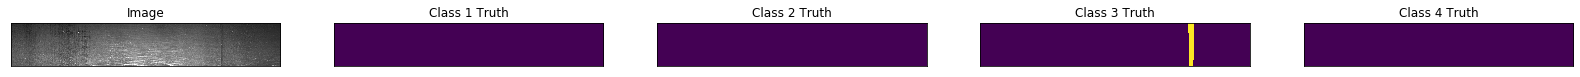

PREDICTED


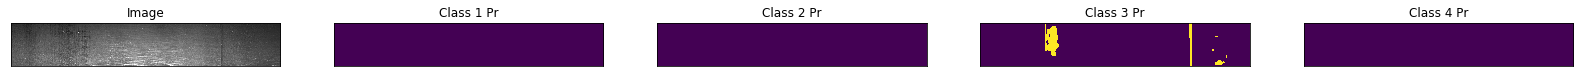




975f12b62.jpg
TRUTH


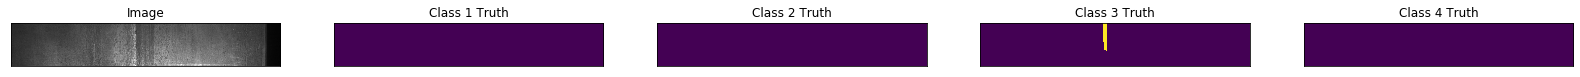

PREDICTED


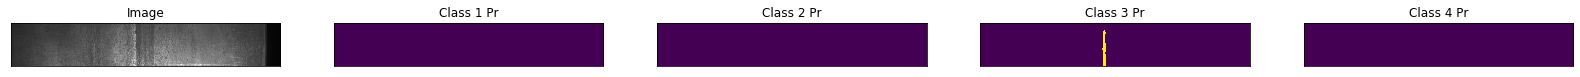




86d953299.jpg
TRUTH


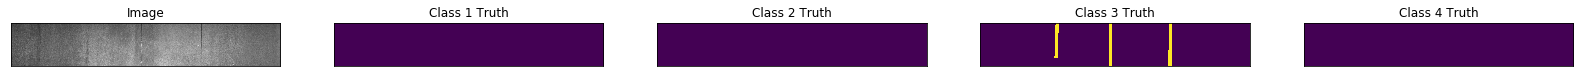

PREDICTED


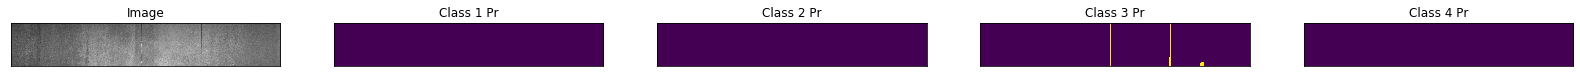

In [70]:
for i in range(10):
    n = np.random.choice(len(test_dataset))
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    print(test_dataset_vis.images_ids[n])
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    print('TRUTH')
    visualize(
        image=image_vis, 
        class_1_truth=gt_mask[0, :, :],
        class_2_truth=gt_mask[1, :, :],
        class_3_truth=gt_mask[2, :, :],
        class_4_truth=gt_mask[3, :, :],
    )
    print('PREDICTED')
    visualize(
        image = image_vis, 
        class_1_pr = pr_mask[0, :, :],
        class_2_pr = pr_mask[1, :, :],
        class_3_pr = pr_mask[2, :, :],
        class_4_pr = pr_mask[3, :, :],
    )
    print('\n\n')

In [0]:
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
# predict_annot_dir = root_dir + '/predict_annot'

# if not os.path.exists(predict_annot_dir):
#     os.mkdir(predict_annot_dir)

# for img_name in os.listdir(predict_dir):
#     img = cv2.imread(predict_dir + '/' + img_name)
#     mask_next = np.zeros((img.shape[0], img.shape[1], 3))
#     plt.imsave(predict_annot_dir + '/' + img_name.split('.')[0] + '.png', mask_next / 255)

In [0]:
# shutil.make_archive('steel', 'zip', root_dir)

In [0]:
predict_dataset_vis = Dataset(
    predict_dir, 
    predict_annot_dir, 
    classes=CLASSES,
)

predict_dataset = Dataset(
    predict_dir, 
    predict_annot_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

In [0]:
subm_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels', 'ClassId'])

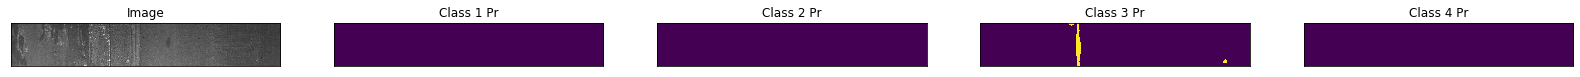

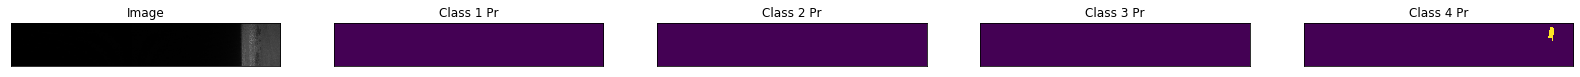

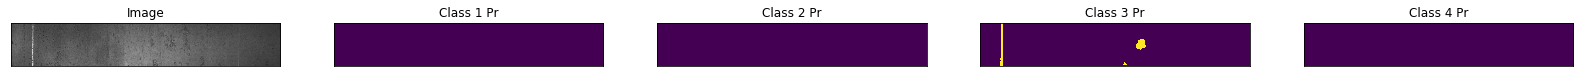

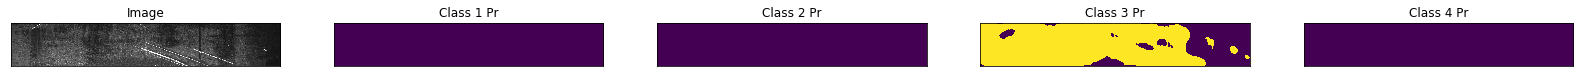

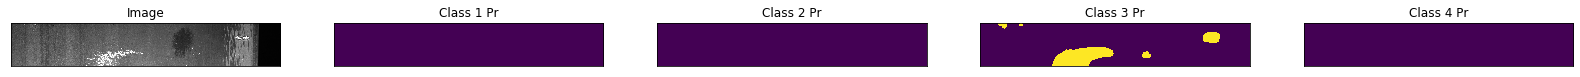

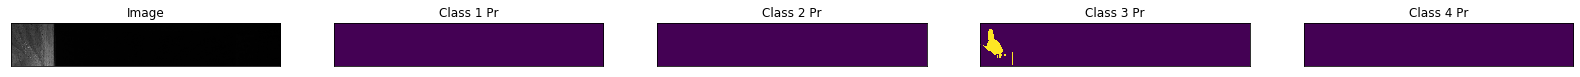

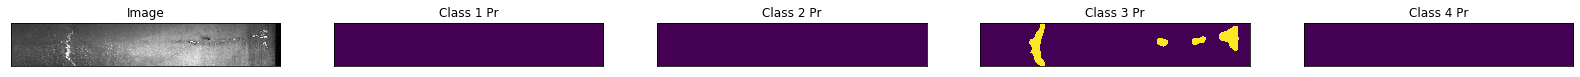

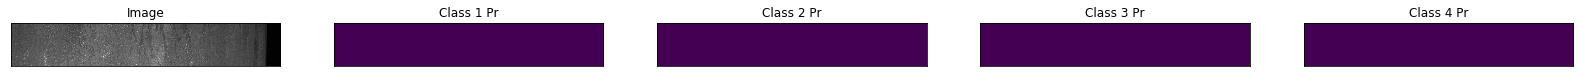

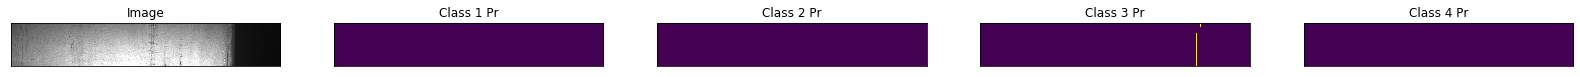

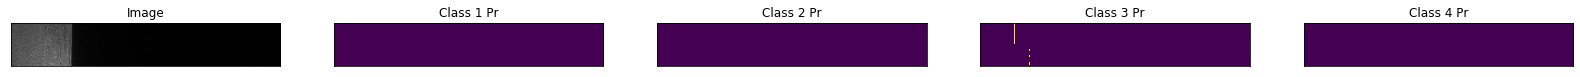

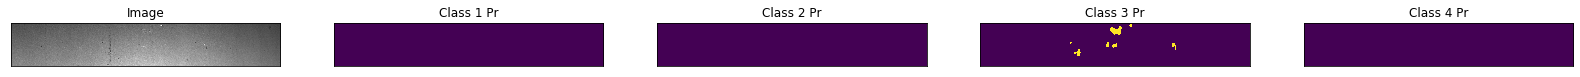

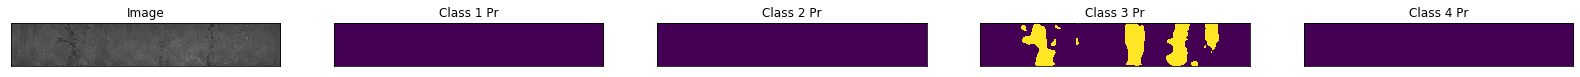

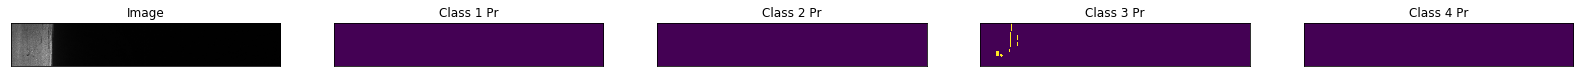

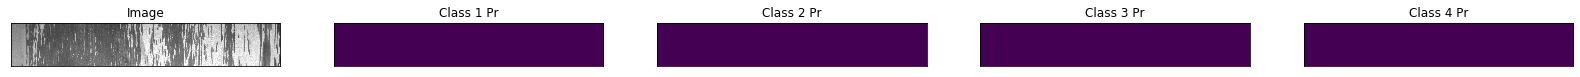

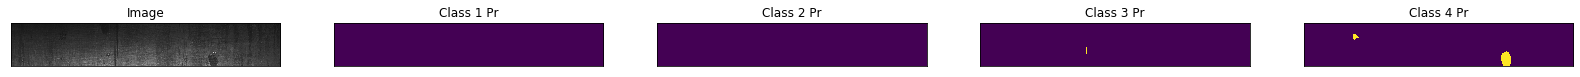

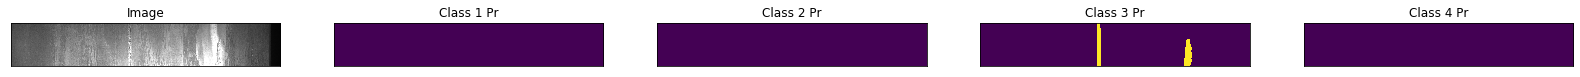

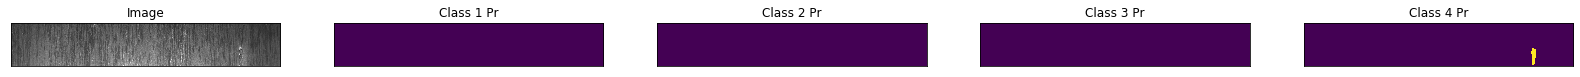

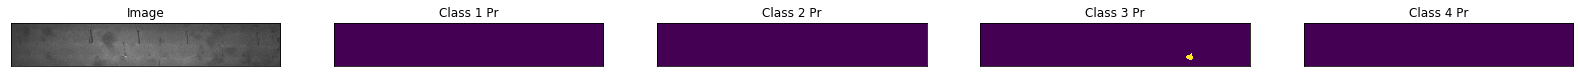

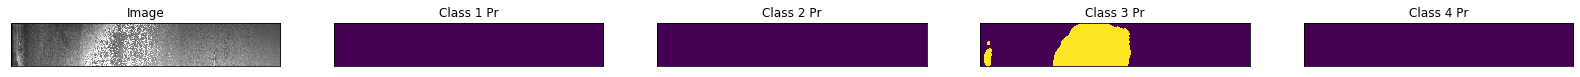

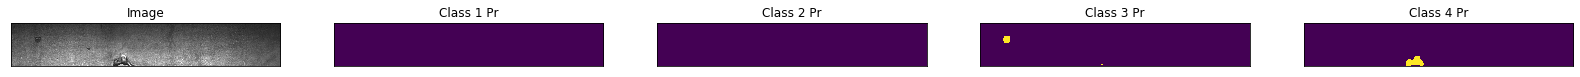

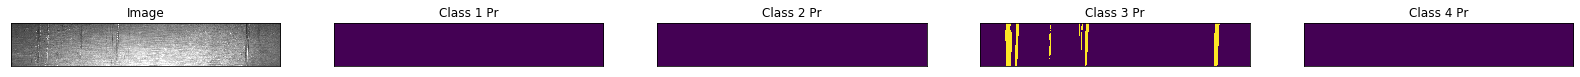

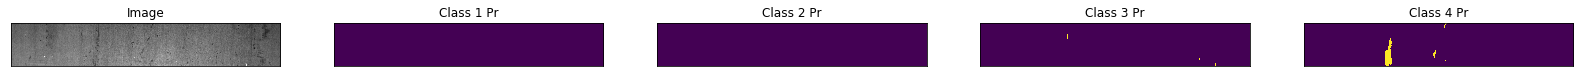

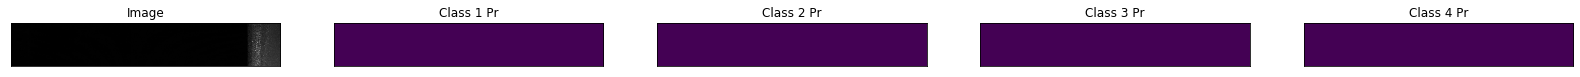

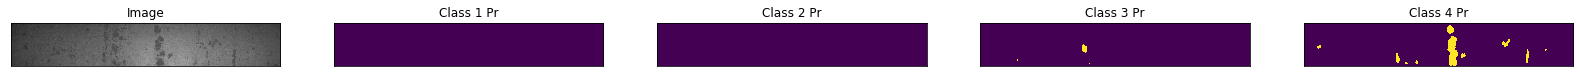

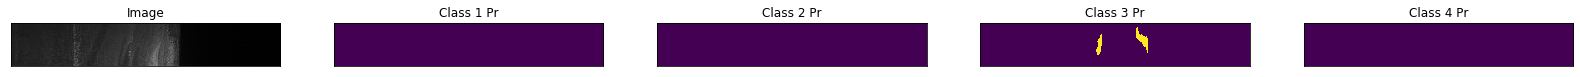

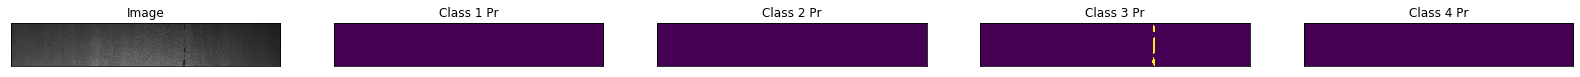

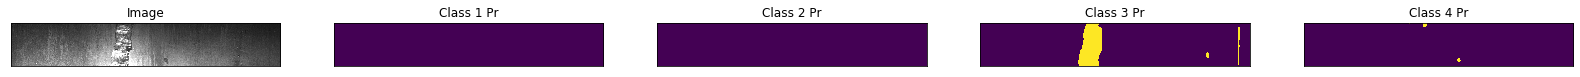

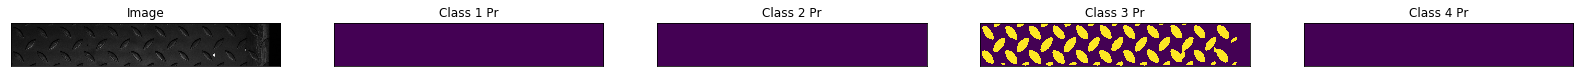

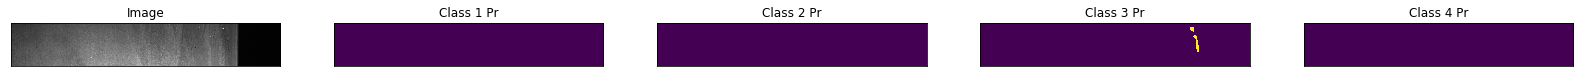

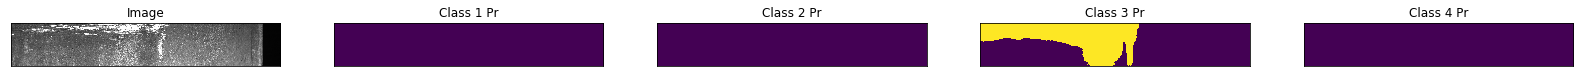

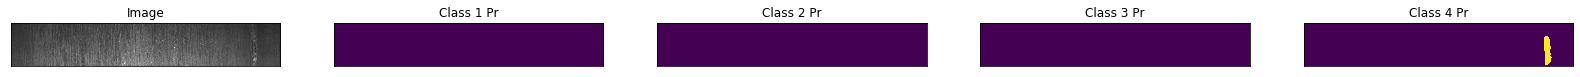

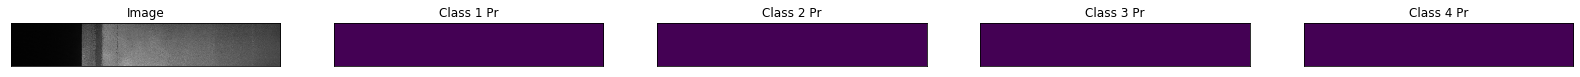

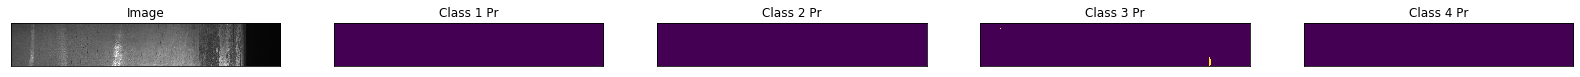

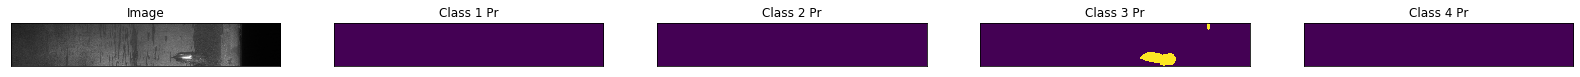

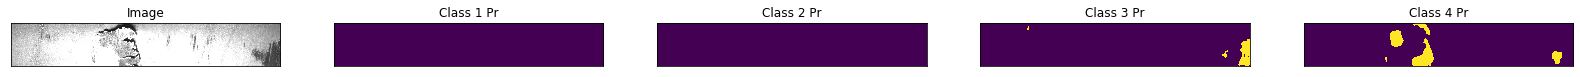

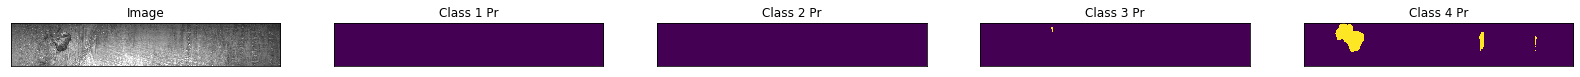

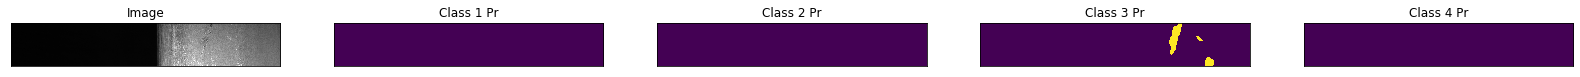

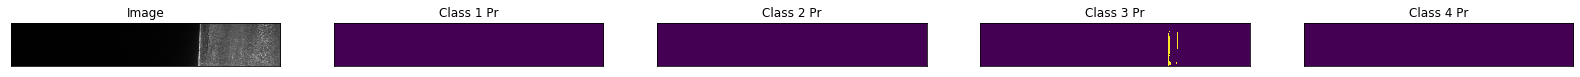

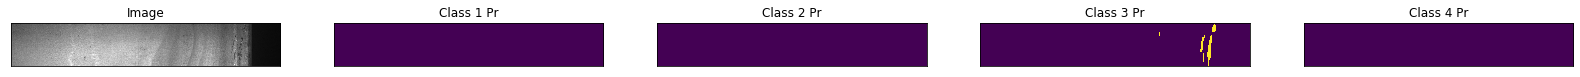

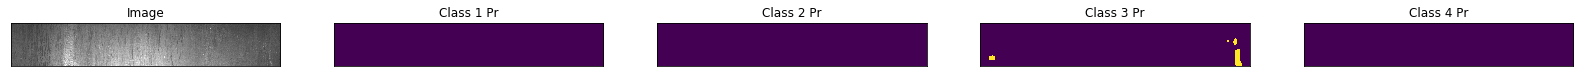

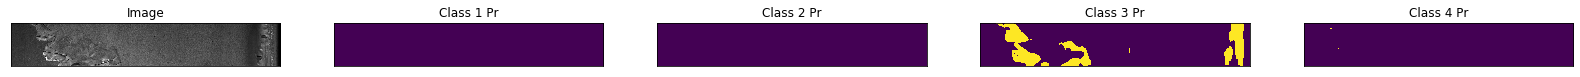

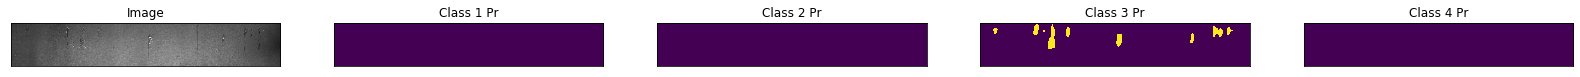

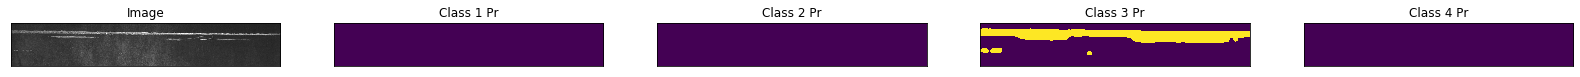

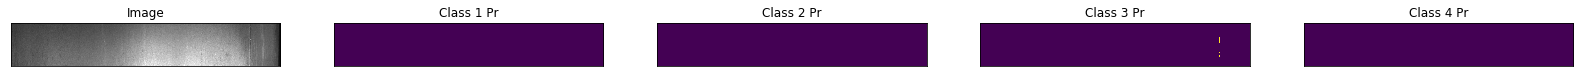

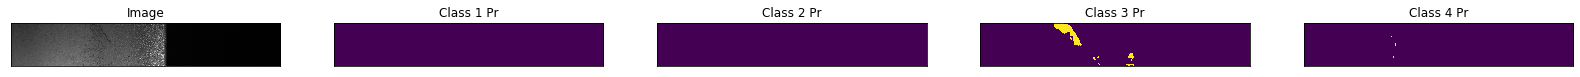

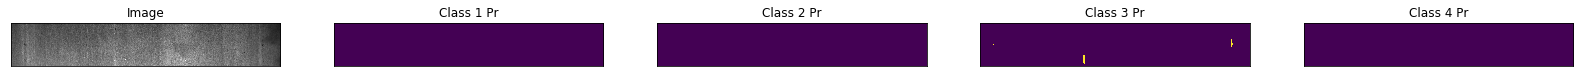

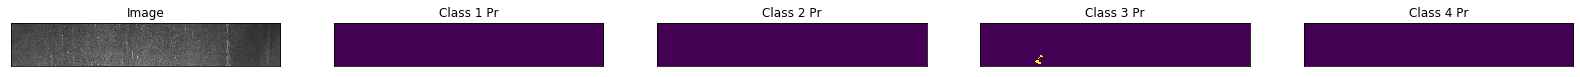

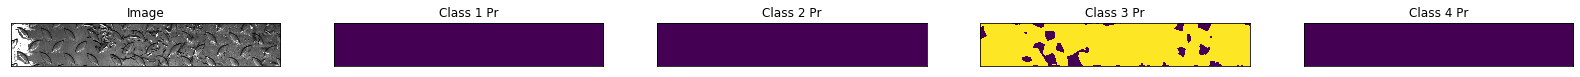

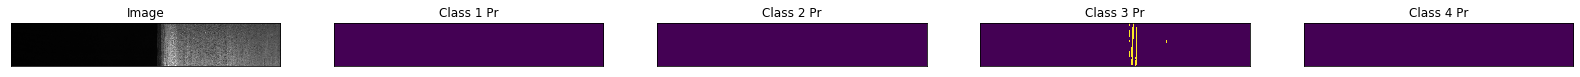

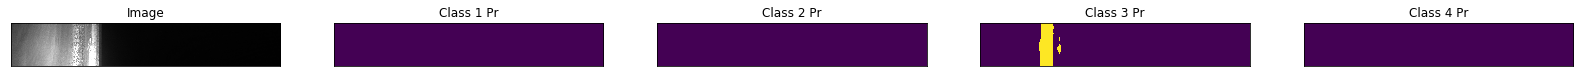

In [87]:
index = 0
# for n in range(len(os.listdir(predict_dir))):
for n in range(0, 50):
    image_vis = predict_dataset_vis[n][0].astype('uint8')
    image, gt_mask = predict_dataset[n]
    gt_mask = gt_mask.squeeze()

    img_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(img_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    visualize(
            image = image_vis, 
            class_1_pr = pr_mask[0, :, :],
            class_2_pr = pr_mask[1, :, :],
            class_3_pr = pr_mask[2, :, :],
            class_4_pr = pr_mask[3, :, :],
        )
    if n % 100 == 0 and n != 0:
        print('Iteration {}'.format(n))
    for i in range(4):
        encoded_pixels = mask2rle(pr_mask[i,:,:])
        if encoded_pixels != '':
            subm_df = subm_df.append({'ImageId' : os.listdir(predict_dir)[n],
                                      'EncodedPixels' : str(encoded_pixels),
                                      'ClassId' : i + 1},
                                     ignore_index = True)
        index += 1

In [89]:
# unique images with defects according to my model's prediction
len(subm_df['ImageId'].unique())

46

In [90]:
subm_df_copy = subm_df.copy()
subm_df_copy = subm_df_copy.sort_values(by=['ImageId'])
subm_df_copy = subm_df_copy.reindex(np.arange(0,subm_df_copy.shape[0]))
subm_df_copy.head()

,ImageId,EncodedPixels,ClassId
0,938d7cf10.jpg,133640 3 133893 9 134148 11 134404 12 134659 1...,3
1,62c457660.jpg,370773 11 371024 17 371277 20 371527 26 371778...,4
2,ece52b68a.jpg,30972 2 31184 15 31204 28 31276 14 31355 38 31...,3
3,f5cd73e33.jpg,111 6 269 123 441 16 485 7 519 240 774 243 103...,3
4,3e1b9d319.jpg,26629 10 26884 12 27139 14 27395 15 27651 16 2...,3


In [0]:
# subm_df.to_csv('/content/Submission_unet_27_epoch_efficientnet-b3_256_512.csv')

# Try example from segmentation models documentation

In [0]:
!pip install segmentation-models-pytorch

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [0]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [0]:
img_annot = cv2.imread(y_train_dir + '/' + os.listdir(y_train_dir)[17])
img_annot[:,:,1]

array([[11, 11, 11, ...,  0,  0,  0],
       [11, 11, 11, ...,  0,  0,  0],
       [11, 11, 11, ...,  0,  0,  0],
       ...,
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3]], dtype=uint8)

In [0]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

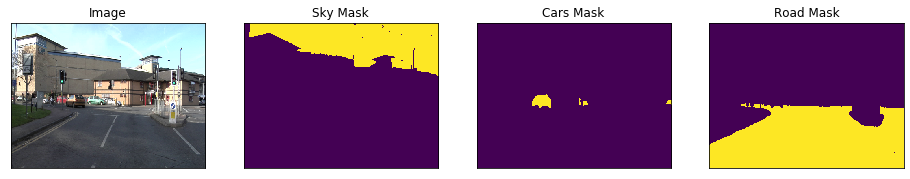

In [0]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['sky', 'car', 'road'])

image, mask = dataset[17]
visualize(
    image=image, 
    sky_mask=mask[:,:,0].squeeze(),
    cars_mask=mask[:,:,1].squeeze(),
    road_mask=mask[:,:,2].squeeze(),
)

In [0]:
mask[:,:,0]

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
import albumentations as albu

In [0]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

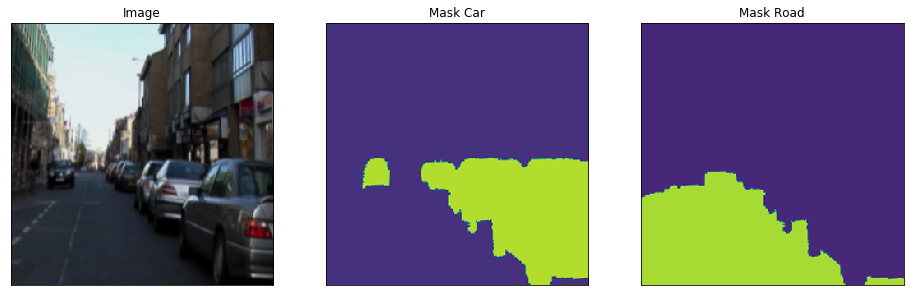

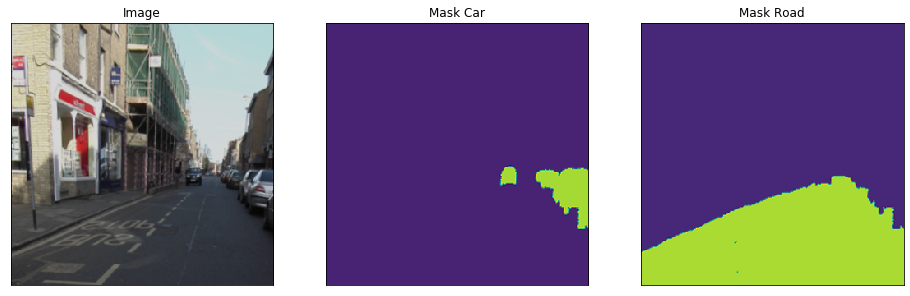

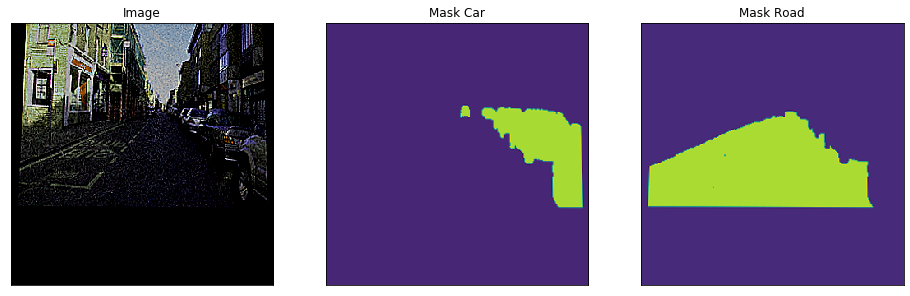

In [0]:
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car', 'road'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[17]
    visualize(
        image=image, 
        mask_car=mask[:,:,0].squeeze(),
        mask_road=mask[:,:,1].squeeze()
    )

In [0]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [0]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car', 'road']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:11<00:00, 355kB/s]


In [0]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [0]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [0]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [0]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 101/101 [00:04<00:00, 24.88it/s, dice_loss - 0.07952, iou_score - 0.8622]
Model saved!

Epoch: 1
train:   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FPN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SENetEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/

valid: 100%|██████████| 101/101 [00:04<00:00, 24.79it/s, dice_loss - 0.06623, iou_score - 0.8816]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:04<00:00, 24.73it/s, dice_loss - 0.0536, iou_score - 0.9037]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:04<00:00, 24.05it/s, dice_loss - 0.05372, iou_score - 0.9021]

Epoch: 4
valid: 100%|██████████| 101/101 [00:04<00:00, 24.35it/s, dice_loss - 0.04528, iou_score - 0.9169]
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [00:04<00:00, 24.33it/s, dice_loss - 0.0345, iou_score - 0.9372]
Model saved!

Epoch: 6
valid: 100%|██████████| 101/101 [00:04<00:00, 23.83it/s, dice_loss - 0.03766, iou_score - 0.9305]

Epoch: 7
valid: 100%|██████████| 101/101 [00:04<00:00, 23.95it/s, dice_loss - 0.03724, iou_score - 0.9309]

Epoch: 8
valid: 100%|██████████| 101/101 [00:04<00:00, 24.59it/s, dice_loss - 0.03219, iou_score - 0.9407]
Model saved!

Epoch: 9
valid: 100%|██████████| 101/101 [00:04<00:00, 24.75it/s, dice_loss - 0.03

In [0]:
best_model = torch.load('./best_model.pth')

In [0]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [0]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:10<00:00, 22.76it/s, dice_loss - 0.04513, iou_score - 0.9183]


In [0]:
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

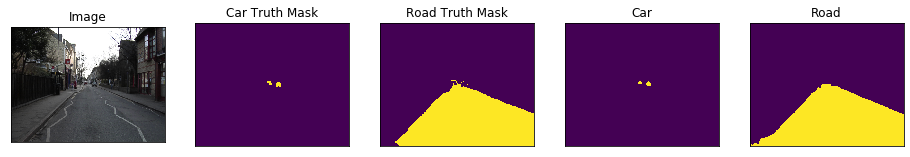

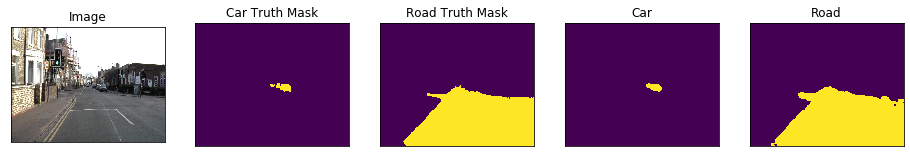

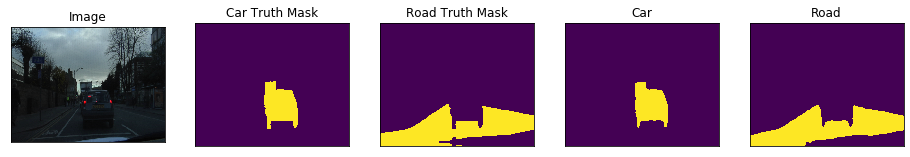

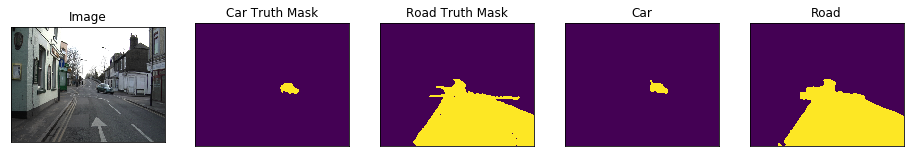

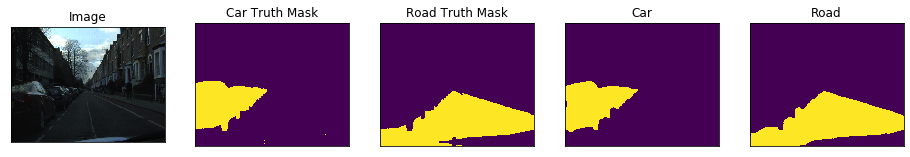

In [0]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
      
    visualize(
        image=image_vis, 
        car_truth_mask=gt_mask[0, :, :],
        road_truth_mask=gt_mask[1, :, :],
        car=pr_mask[0, :, :],
        road=pr_mask[1, :, :],
    )